### Imports and utils

In [3]:
import re, json, os, yaml
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract Timeloop Statistics from output files
def extract_tl_stats(file_path):
  with open(file_path, "r") as f:
    stats = f.read()

    res = re.findall(r'Utilization:\s(\d+.\d+)\s', stats, re.DOTALL)
    utilization = float(res[0])

    res = re.findall(r'Total\s+= (\d+.\d+)\s', stats, re.DOTALL)
    efficiency = float(res[0])

    res = re.findall(r'Cycles:\s(\d+)', stats, re.DOTALL)
    cycles = int(res[0])

    res = re.findall(r'Energy:\s(\d+.\d+)\suJ', stats, re.DOTALL)
    energy = float(res[0])

    f.close()

  return utilization, efficiency, cycles, energy

# Generate dataframe considering results for each workload and layer-workload lookups
def generate_dataframe(folder, method, network, exclude=[], end=None):
  lookup_file = '../workloads/lookups.yaml'
  with open(lookup_file, 'r') as f:
    lookup_yaml = yaml.safe_load(f)
      
  layer_workload_lookup = lookup_yaml['layer_workload_lookups'][network]
  network_name = lookup_yaml['network_names'][network]

  workload_ids = sorted(list(set(layer_workload_lookup)))
  
  missing = []
  total_energy = total_latency = 0
  for w in layer_workload_lookup[:end]:
    stats_file = f'./{folder}/{network}/{str(w).zfill(len(str(len(workload_ids))))}/timeloop-model.stats.txt'
    if not os.path.isfile(stats_file) :
      print('gift', method, network)
      missing.append((network, w))
      continue
    if (network, w) in exclude:
      continue
    utilization, efficiency, cycles, energy = extract_tl_stats(stats_file)
    #print(method, network, w, utilization, efficiency, cycles, energy)
    total_energy += energy
    total_latency += cycles

  with open(f'./{folder}/runtime.json', 'r') as runtime_file:
    runtime_dict = json.load(runtime_file)
    runtime = runtime_dict[network]
  
  df_dict = {
    'Method': method,
    'Network': network_name,
    'Energy [uJ]': total_energy,
    'Cycles': total_latency,
    'EDP': total_energy*total_latency,
    'Runtime [s]': runtime,
  }

  return missing, pd.DataFrame(df_dict, index=[0])

# Plot Styling
font_size = 8
_new_black = '#373737'
color_grid = '#F1F5B7'
color1 = '#EBF095'
color2 = '#DEE600'
sns.set_theme(style='ticks', font_scale=0.75, rc={
    'font.family': 'serif',
    'font.serif': ['Linux Libertine O'],
    'svg.fonttype': 'none',
    'text.usetex': False,
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'font.size': font_size,
    'axes.labelsize': font_size,
    'axes.titlesize': font_size,
    'axes.labelpad': 2,
    'axes.linewidth': 1,
    'axes.titlepad': 4,
    'lines.linewidth': 1,
    'legend.fontsize': font_size,
    'legend.title_fontsize': font_size,
    'xtick.labelsize': font_size,
    'ytick.labelsize': font_size,
    'xtick.major.size': 2,
    'xtick.major.pad': 1,
    'xtick.major.width': 1,
    'ytick.major.size': 2,
    'ytick.major.pad': 1,
    'ytick.major.width': 1,
    'xtick.minor.size': 2,
    'xtick.minor.pad': 1,
    'xtick.minor.width': 1,
    'ytick.minor.size': 2,
    'ytick.minor.pad': 1,
    'ytick.minor.width': 1,
    'text.color': _new_black,
    'patch.edgecolor': _new_black,
    'patch.force_edgecolor': False,
    'hatch.color': _new_black,
    'axes.edgecolor': _new_black,
    'axes.labelcolor': _new_black,
    'xtick.color': _new_black,
    'ytick.color': _new_black,
    'figure.figsize': (3.34,1.5),
    'axes.grid' : True,
    'grid.color': color_grid,
})

### EDP Comparison

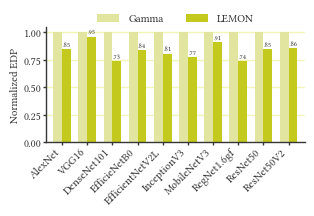

In [5]:
plot_ref = False # Set true to plot reference results
ref_sfx = '-ref' if plot_ref else ''

lookup_file = '../workloads/lookups.yaml'
with open(lookup_file, 'r') as f:
    lookup_yaml = yaml.safe_load(f)

data = pd.DataFrame()
for network in lookup_yaml['networks']:
    gamma_missing, gamma_data = generate_dataframe(f'results{ref_sfx}/gamma', 'Gamma', network, end=-3)
    lemon_missing, lemon_data = generate_dataframe(f'results{ref_sfx}/lemon', 'LEMON', network, end=-3, exclude=gamma_missing)
    data = pd.concat([data, gamma_data, lemon_data], ignore_index=True)

data['Normalized EDP'] = data.groupby('Network')['EDP'].transform(lambda x: x/x.max())

g = sns.barplot(data, x='Network', y='Normalized EDP', hue='Method', width=0.7, palette=[color1, color2])
_ = plt.xticks(rotation=45, ha='right')
sns.move_legend(g, "upper center", bbox_to_anchor=(0.5, 1.2), ncol=2, title=None, frameon=False)
g.margins(x=0.03)

for p in g.patches:
    if p.get_height() < 1.0:
        g.annotate(f'{p.get_height():.2f}'.lstrip('0'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', xytext = (0.1, 3.3), textcoords = 'offset points', fontsize=5)

sns.despine()
_ = g.set_xlabel(None)

#plt.savefig('gamma.pdf', bbox_inches='tight', pad_inches = 0)

### Runtime Comparison

   Method          Network  Energy [uJ]    Cycles           EDP  Runtime [s]
0   Gamma          AlexNet     12020.34    808148  9.714214e+09   377.656284
1   LEMON          AlexNet     11379.70    701420  7.981949e+09    40.447534
2   Gamma            VGG16     96410.01  15236704  1.468971e+12  1151.339625
3   LEMON            VGG16     92880.42  15107680  1.403208e+12   461.470582
4   Gamma      DenseNet101     41709.23   6169508  2.573254e+11  4518.935736
5   LEMON      DenseNet101     36203.23   5919899  2.143195e+11   801.647391
6   Gamma     EfficieNetB0      3458.90    374871  1.296641e+09  1344.711381
7   LEMON     EfficieNetB0      3129.33    343075  1.073595e+09   214.472873
8   Gamma  EfficientNetV2L    364259.10  56952502  2.074547e+13  1926.071282
9   LEMON  EfficientNetV2L    302405.70  54344166  1.643399e+13  1605.452890
10  Gamma      InceptionV3     36568.61   6408482  2.343493e+11  2082.995611
11  LEMON      InceptionV3     31100.87   5671788  1.763975e+11   276.740113

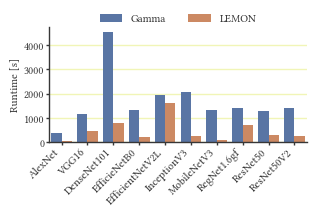

In [4]:
lookup_file = '../workloads/lookups.yaml'
with open(lookup_file, 'r') as f:
    lookup_yaml = yaml.safe_load(f)

data = pd.DataFrame()
for network in lookup_yaml['networks']:
    gamma_missing, gamma_data = generate_dataframe(f'results{ref_sfx}/gamma', 'Gamma', network, end=None)
    lemon_missing, lemon_data = generate_dataframe(f'results{ref_sfx}/lemon', 'LEMON', network, end=None, exclude=gamma_missing)
    data = pd.concat([data, gamma_data, lemon_data], ignore_index=True)

print(data)

data['Normalized Runtime'] = data.groupby('Network')['Runtime [s]'].transform(lambda x: x/x.max())

g = sns.barplot(data, x='Network', y='Runtime [s]', hue='Method')
_ = plt.xticks(rotation=45, ha='right')
sns.move_legend(g, "upper center", bbox_to_anchor=(0.5, 1.2), ncol=2, title=None, frameon=False)
sns.despine()
_ = g.set_xlabel(None)